In [22]:
import warnings; warnings.simplefilter('ignore')
from sklearn.datasets import fetch_20newsgroups
from gensim import models
import scipy.spatial.distance as distance
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [8]:
from keras.models import load_model, Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D
from keras.layers import Multiply, concatenate, Activation, Dropout, Reshape, Lambda
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
from keras import backend as K

In [10]:
def plot_history(history):
    ## As loss always exists
    epochs = range(1,len(history.history['loss']) + 1)
    
    ## Loss
    plt.figure(1)
    plt.plot(epochs, history.history['loss'], 'b', label='Training loss ')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation loss ')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    plt.plot(epochs, history.history['acc'], 'b', label='Training accuracy ')
    plt.plot(epochs, history.history['val_acc'], 'g', label='Validation accuracy ')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Get the Data

In [11]:
dataset = fetch_20newsgroups(subset= 'all',shuffle=True, random_state=1)#, remove=('headers', 'footers', 'quotes'))

In [12]:
from nltk.corpus import stopwords
from string import punctuation
def clean_text(texts,  min_length = 2):
    clean = []
    #don't remove apostrophes
    translator = str.maketrans(punctuation.replace('\'',' '), ' '*len(punctuation))
    for text in texts:
        text = text.translate(translator)
        tokens = text.split()
        # remove not alphabetic tokens
        tokens = [word.lower() for word in tokens if word.isalpha()]
        # filter out stop words
        stop_words = stopwords.words('english')
        tokens = [w for w in tokens if not w in stop_words]
        # filter out short tokens
        tokens = [word for word in tokens if len(word) >= min_length]
        tokens = ' '.join(tokens)
        clean.append(tokens)
    return clean

In [13]:
# tagged data from doc2vec training
def tag_text(all_text, tag_type =''):
    tagged_text = []
    for i, text in enumerate(all_text):
        tag = i
        tagged_text.append(models.doc2vec.TaggedDocument(text.split(), [tag]))
    return tagged_text

In [14]:
n_samples = len(dataset.data)
data = clean_text(dataset.data)
tagged_data = tag_text(data)
data_labels = dataset.target
data_label_names = dataset.target_names

In [15]:
cat_data_labels = to_categorical(data_labels)

In [16]:
num_labels = len(data_label_names)
print(num_labels)

20


### 20 Topics

In [17]:
data_label_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 18846 Posts

In [18]:
len(data)

18846

## Wrappers to perform training-testing and cross-validation

In [99]:
#randomly split the data set and the labels into n_cv folds and select fold_n as testing data and the rest as training
def create_single_fold(data, labels, n_cv, fold_n):
    data_size = data.shape[0]
    cv_folds = np.random.randint(0, high = n_cv, size = data_size)
    train_data = data[cv_folds != fold_n]
    train_labels = labels[cv_folds != fold_n]
    test_data = data[cv_folds == fold_n]
    test_labels = labels[cv_folds == fold_n]
    return (train_data, train_labels, test_data, test_labels)

#randomly split the data set and the labels into n_cv folds and yeild testing data and training data for each fold
def create_all_folds(data, labels, n_cv):
    data_size = data.shape[0]
    cv_folds = np.random.randint(0, high = n_cv, size = data_size)
    for fold_n in range(n_cv):
        train_data = data[cv_folds != fold_n]
        train_labels = labels[cv_folds != fold_n]
        test_data = data[cv_folds == fold_n]
        test_labels = labels[cv_folds == fold_n]
        yield (train_data, train_labels, test_data, test_labels)

# Tfidf representation of the document-word matrix

Tfidf - term frequency inverse document frequency -   measures the importance of terms in the documents based on how frequently they occur in the corpus of documents. It gives more weight to terms appearing in fewer documents.

The 'raw' formula for tfidf is 

$tfidf_{i,j} = tf_{i,j} \times idf_i =  tf_{i,j} \times log(\frac{N}{df_i})$

Here $tf_{i,j}$ is the frequency of term $i$ in document $j$, $idf_i$ is the inverse document frequency, $N$ is the number of documents, and $df_i$ is the number of documents in which term $i$ appears.

In practice the raw formula is modified. 1 is added to the definition of $idf_i$ to avoid the inverse document frequency turning to 0 when the term is present in all documents. 

In addition TfidfVectorizer provides an option of either $l1$ or $l2$ normalization for $tfidf_{i,j}$

Tfidf representation is used with  Dense Neural Networks

In [19]:
def sklearn_tokenize(input_texts, vocab_size, ngram_range, mystopwords = [],  max_df = 1.0, min_df = 1):
    vectorizer = TfidfVectorizer(max_df=max_df, max_features=vocab_size, ngram_range = ngram_range,
                                     min_df=min_df,  norm='l2',
                                     use_idf=True, smooth_idf = False)
    X = vectorizer.fit_transform(input_texts)
    return (X.todense(), vectorizer)

In [20]:
#pick the top VOCAB_SIZE words from the corpus based on their counts
VOCAB_SIZE = 5000

#tokenize raw texts using sklearn
tfidf_data, vectorizer = sklearn_tokenize(data,  VOCAB_SIZE, (1,1), max_df = 0.5)
print(tfidf_data.shape)

(18846, 5000)


In [56]:
# split the tfidf data into training/validation = 4/1 
train_size = 0.8
x_tfidf_train, x_tfidf_test,y_tfidf_train,  y_tfidf_test = \
                        train_test_split(tfidf_data, cat_data_labels, train_size = train_size)

## DenseNN  with 1 Hidden Layer

In [27]:
BATCH_SIZE = 128

In [60]:
input_size = VOCAB_SIZE
dropout = 0.3
activation = 'tanh'
layer_size = 60
inputs = Input(shape = (input_size,),  name='dnn_input')
x = Dense(layer_size, activation=activation, name ='hidden_dnn')(inputs)
x = Dropout(dropout, name='dropout')(x)
preds = Dense(num_labels, activation='softmax', name = 'output_dnn')(x)

model = Model(inputs, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 5000)              0         
_________________________________________________________________
hidden_dnn (Dense)           (None, 60)                300060    
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
output_dnn (Dense)           (None, 20)                1220      
Total params: 301,280
Trainable params: 301,280
Non-trainable params: 0
_________________________________________________________________


## Explanation: Output Shape and Number of Parameters 

```
Layer (type)                 Output Shape              Param #   
=================================================================
dnn_input (InputLayer)       (None, 5000)              0         
```
#### Output Shape
- None: batch_size will be determined run-time
- 5000: Vocabular Size

```
_________________________________________________________________
hidden_dnn (Dense)           (None, 60)                300060    
```
#### Output Shape
- None: batch_size will be determined run-time
- 60: Hidden Layer Size

#### Number of Parameters 

- (Vocabulary Size +1)  x Hidden Layer Size =  $5001 * 60 = 300,060$  
    - 1 is added for the bias term

```     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
output_dnn (Dense)           (None, 20)                1220   
```
#### Output Shape
- None: batch_size will be determined run-time
- 20: Output Layer Size

#### Number of Parameters
- (Hidden Layer Size + 1) x  Output Layer Size = $61 * 20 = 1,220$
    - 1 is added for the bias term


In [62]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_tfidf_train, y_tfidf_train, validation_data=(x_tfidf_test, y_tfidf_test), 
                    epochs=30, batch_size=BATCH_SIZE, callbacks=[earlystop])

Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 2s 155us/step - loss: 2.6063 - acc: 0.6430 - val_loss: 2.0512 - val_acc: 0.7926
Epoch 2/30
15076/15076 [==============================] - 2s 118us/step - loss: 1.5152 - acc: 0.8252 - val_loss: 1.1280 - val_acc: 0.8276
Epoch 3/30
15076/15076 [==============================] - 2s 121us/step - loss: 0.8554 - acc: 0.8721 - val_loss: 0.7632 - val_acc: 0.8507
Epoch 4/30
15076/15076 [==============================] - 2s 122us/step - loss: 0.5729 - acc: 0.9036 - val_loss: 0.6048 - val_acc: 0.8671
Epoch 5/30
15076/15076 [==============================] - 2s 120us/step - loss: 0.4257 - acc: 0.9240 - val_loss: 0.5222 - val_acc: 0.8735
Epoch 6/30
15076/15076 [==============================] - 2s 119us/step - loss: 0.3314 - acc: 0.9399 - val_loss: 0.4718 - val_acc: 0.8793
Epoch 7/30
15076/15076 [==============================] - 2s 117us/step - loss: 0.2658 - acc: 0.9532 - val_loss: 0.4395 - v

In [69]:
print ('Best validation accuracy is ', max(history.history['val_acc']))

Best validation accuracy is  0.8933687006130775


### Overfitting occurs if trained too much 

Note, early stopping criteria kicked in at Epoch 21

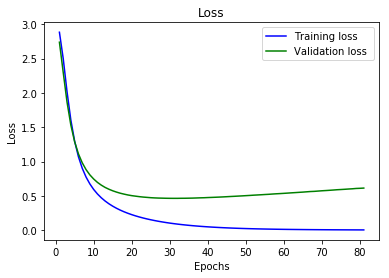

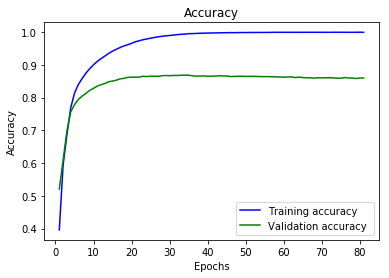

In [798]:
plot_history(history)

<img src="images/TFIDF Accuracy.png" alt="Drawing" style="width: 600px;" />

### Increase of the vocabulary size allows for increase in the network size without deterioration of accuracy

# DenseNN for Doc2vec

### Document Embedding Dimensions

In [65]:
DOC2VEC_SIZE = 1000

### Train Doc2vec embedding using gensim

In [66]:
model_dbow = models.Doc2Vec(dm=0, dbow_words = 0, vector_size=DOC2VEC_SIZE, min_count=4, alpha=0.065, min_alpha=0.005)
model_dbow.build_vocab(tagged_data)
model_dbow.train(tagged_data, total_examples=len(tagged_data), epochs=30)

### Input to a DNN is the Doc2vec vector

In [67]:
dbow_doc2vec = []
for i in range(n_samples):
    dbow_doc2vec.append(model_dbow.docvecs[i])
dbow_doc2vec = np.array(dbow_doc2vec)
print (dbow_doc2vec.shape)

(18846, 1000)


### dbow_doc2vec is a matrix with the dimensions Number of Posts x Doc2vec Embedding size = 18846 x 1000 

In [70]:
# split the tfidf data into training/validation = 4/1 
train_size = 0.8
x_doc_train, x_doc_test, y_doc_train, y_doc_test = \
                        train_test_split(dbow_doc2vec, cat_data_labels, train_size = train_size)

In [71]:
input_size = DOC2VEC_SIZE
dropout = 0.3
activation = 'tanh'
layer_size = 100
inputs = Input(shape = (input_size,),  name='dnn_input')
x = Dense(layer_size, activation=activation, name ='hidden_dnn')(inputs)
x = Dropout(dropout, name='dropout')(x)
preds = Dense(num_labels, activation='softmax', name = 'output_dnn')(x)

model = Model(inputs, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 1000)              0         
_________________________________________________________________
hidden_dnn (Dense)           (None, 100)               100100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
output_dnn (Dense)           (None, 20)                2020      
Total params: 102,120
Trainable params: 102,120
Non-trainable params: 0
_________________________________________________________________


## Explanation of Output Shape and Number of Parameters 

```
Layer (type)                 Output Shape              Param #   
=================================================================
dnn_input (InputLayer)       (None, 1000)              0         
```
#### Output Shape
- None: batch_size will be determined run-time
- 1000: Doc2Vec Embedding Size

```
_________________________________________________________________

hidden_dnn (Dense)           (None, 100)               100100      
```
#### Output Shape
- None: batch_size will be determined run-time
- 100: Hidden Layer Size

#### Number of Parameters 

- (Document Embedding Dimensions + 1)  x Hidden Layer Size =  $1001 \times 100 = 100,100$
    - 1 is added for the bias term

```
_________________________________________________________________
dropout (Dropout)          (None, 100)               0         
_________________________________________________________________
output_dnn (Dense)           (None, 20)                2020   
```
#### Output Shape
- None: batch_size will be determined run-time
- 20: Output Layer Size

#### Number of Parameters
- (Hidden Layer Size + 1) x  Output Layer Size = $101 \times 20 = 2,020$
    - 1 is added for the bias term


In [73]:
%%time
earlystop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_doc_train, y_doc_train, validation_data=(x_doc_test, y_doc_test), 
                    epochs=30, batch_size=BATCH_SIZE, callbacks=[earlystop])

Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 1s 66us/step - loss: 1.4975 - acc: 0.6500 - val_loss: 0.7110 - val_acc: 0.8435
Epoch 2/30
15076/15076 [==============================] - 0s 32us/step - loss: 0.6188 - acc: 0.8394 - val_loss: 0.5147 - val_acc: 0.8650
Epoch 3/30
15076/15076 [==============================] - 0s 31us/step - loss: 0.4771 - acc: 0.8683 - val_loss: 0.4578 - val_acc: 0.8663
Epoch 4/30
15076/15076 [==============================] - 0s 29us/step - loss: 0.4094 - acc: 0.8859 - val_loss: 0.4357 - val_acc: 0.8706
Epoch 5/30
15076/15076 [==============================] - 0s 32us/step - loss: 0.3667 - acc: 0.8941 - val_loss: 0.4256 - val_acc: 0.8666
Epoch 6/30
15076/15076 [==============================] - 0s 30us/step - loss: 0.3345 - acc: 0.9036 - val_loss: 0.4267 - val_acc: 0.8674
Epoch 7/30
15076/15076 [==============================] - 0s 29us/step - loss: 0.3181 - acc: 0.9042 - val_loss: 0.4209 - val_acc:

In [74]:
print ('Best validation accuracy is ', max(history.history['val_acc']))

Best validation accuracy is  0.8933687006130775


### Overfitting occurs if trained too much 

Note, early stopping criteria kicked in at Epoch 13

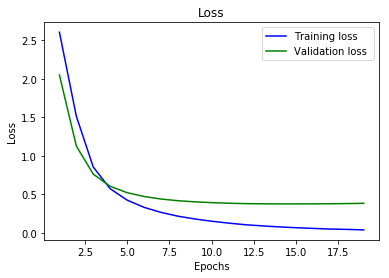

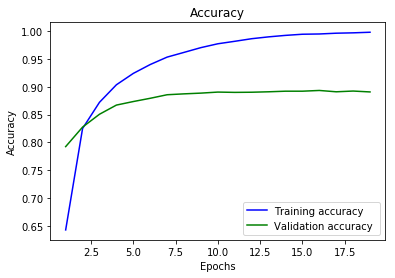

In [75]:
plot_history(history)

<img src="images/DOC2VEC Accuracy.png" alt="Drawing" style="width: 600px;" />

# Word Embedding

## ```make_sequence``` 
```make_sequence``` converts a list of texts into a matrix of tokens using ```Tokenizer```.
```Tokenizer``` turns text (a sentence, a paragraph, etc.) into sequences of tokens: word $\rightarrow$ token.
word_index is the dictionary used to transform the words into the tokens: 
```
{'UNK': 1,
'might', 77,
'play', 317,
'baseball', 616,
'lets', 2429,
'rain', 3057,
'tomorrow', 3102
 ...
```
Sequences have to be the same size to be fed into a NN, hence padding with 0's to max_sequence_length.
E.g. 2 input sentences *'Lets play baseball tomorrow'* and *'It might rain tomorrow'* and max_sequence_length = 5. The output of ```make_sequence``` will be a matrix (*'it'* is a stopword):

$
\begin{array}{cc}
\textit {lets play baseball tomorrow} \\
\textit {might rain tomorrow}\\
\end{array}
\begin{bmatrix}
2429 & 317& 616& 3102& 0 \\
77 & 3057& 3102& 0& 0\\
\end{bmatrix}
$


## Keras ```Embedding``` Layer
```Embedding``` turns each token, and by extension each word, into a vector, the size of the vector is EMBEDDING_DIM.

E.g. EMBEDDING_DIM = 3,  max_sequence_length = 5. Sentences *'Lets play baseball tomorrow'* will converted into something like this matrix 
$
\begin{matrix}
lets \\
play\\
baseball\\
tomorrow\\ 
\\
\end{matrix}
\begin{pmatrix}
2429 \\
317\\
616\\
3102\\ 
0\\
\end{pmatrix}
\begin{bmatrix}
0.1 & 0.3& 0.7 \\
0.2& -0.1& 0.6\\
0.1& 0.6& -0.2\\
-0.7& 0.1& 0.8\\ 
0.0& 0.0& 0.0\\
\end{bmatrix}
$

and *'It might rain tomorrow'* will converted into something like this matrix

$
\begin{matrix}
might \\
rain\\
tomorrow\\ 
\\
\\
\end{matrix}
\begin{pmatrix}
77 \\
3057\\
3102\\ 
0\\
0\\
\end{pmatrix}
\begin{bmatrix}
-0.4 & 0.2& 0.9 \\
0.5& 0.1& -0.2\\
-0.7& 0.1& 0.8\\ 
0.0& 0.0& 0.0\\
0.0& 0.0& 0.0\\
\end{bmatrix}
$

## Combination
Combination of ```make_sequence``` and ```Embedding``` converts a list of texts into a 3D tensor:
<img src="images/3dtensor.png" alt="Drawing" style="width: 300px;" />

In [76]:
def make_sequences(input_texts, max_nb_words, max_sequence_length = 0, percentile = 99, verbose = 0, output_tokenizer = False):
# input_texts is a list of strings/texts
# if max_sequence_length is not given, it is set to the percentile of all the lengths of input_texts
# select top vocab_size words based on the word counts
# word_index is the dictionary used to transform the words into the tokens. 
    tokenizer = Tokenizer(oov_token='UNK',num_words=max_nb_words+1)# <= +1 because tokenizer is 1 indexed
    tokenizer.fit_on_texts(input_texts)
    sequences = tokenizer.texts_to_sequences(input_texts)
    ml = [len(s) for s in sequences]
    if max_sequence_length == 0:
        max_sequence_length = int(np.percentile(ml, percentile))
    #padding can be done before 'pre' ore after 'post' the existing text
    data = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
#the fix below is found in https://github.com/keras-team/keras/issues/8092
#TODO follow on how they fix it
    word_index = {e:i for e,i in tokenizer.word_index.items()  if i <= max_nb_words} # <= because tokenizer is 1 indexed
#    word_index[tokenizer.oov_token] = max_nb_words + 1
    if verbose > 0:
        print('Found %s unique tokens.' % len(tokenizer.word_index))
        print (len(input_texts))
        print (len(sequences))
    if verbose > 1:
        out = plt.plot(ml, 'b.')
    if output_tokenizer:
        return (data , word_index, tokenizer)
    return (data , word_index)

In [77]:
VOCAB_SIZE = 5000
# word_index is the dictionary used to transform the words into the tokens. 
#use the default of 99 percentile to define MAX_SEQUENCE_LENGTH
sequence_data, word_index = make_sequences(data, VOCAB_SIZE, percentile=99)

print (sequence_data.shape)
MAX_SEQUENCE_LENGTH = sequence_data.shape[1]
print (MAX_SEQUENCE_LENGTH)

(18846, 1100)
1100


### sequence_data is a matrix with the dimensions Number of Posts x MAX_SEQUENCE_LENGTH = 18846 x 11000 

#### Find the tokens for the words used in the explanation above

In [78]:
words = ['lets','play', 'baseball',  'tomorrow','it','rain','might']
[[i,e] for i,e in word_index.items() if i in words]

[['might', 77],
 ['play', 317],
 ['baseball', 616],
 ['lets', 2429],
 ['rain', 3057],
 ['tomorrow', 3102]]

## Dense Neural Network (DNN) with Word Embedding

In [91]:
# split the tfidf data into training/validation = 4/1 
train_size = 0.8
x_train, x_test, y_train, y_test = \
                        train_test_split(sequence_data, cat_data_labels, train_size = train_size)

In [92]:
EMBEDDING_DIM = 64
layer_size = 25
dropout = 0.1
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='dnn_input')
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, name = 'embedding_dnn')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten(name='flatten_dnn')(embedded_sequences)
x = Dense(layer_size, activation='relu', name ='hidden_dense_dnn')(x)
x = Dropout(dropout, name='dropout')(x)
preds = Dense(num_labels, activation='softmax', name = 'output_dnn')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [93]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 1100)              0         
_________________________________________________________________
embedding_dnn (Embedding)    (None, 1100, 64)          320064    
_________________________________________________________________
flatten_dnn (Flatten)        (None, 70400)             0         
_________________________________________________________________
hidden_dense_dnn (Dense)     (None, 25)                1760025   
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
output_dnn (Dense)           (None, 20)                520       
Total params: 2,080,609
Trainable params: 2,080,609
Non-trainable params: 0
_________________________________________________________________


## Explanation of Output Shape and Number of Parameters 

```
Layer (type)                 Output Shape              Param #   
=================================================================
dnn_input (InputLayer)         (None, 1100)              0      
```
#### Output Shape
- None: batch_size will be determined run-time
- 1100: Sequence Length

```
_________________________________________________________________
embedding_dnn (Embedding)      (None, 1100, 64)          320064      
```
#### Output Shape
- None: batch_size will be determined run-time
- 1100: Sequence Length
- 64: Word Embedding Dimensions

#### Number of Parameters 

- (Vocabulary Size + 1)  x Word Embedding Dimensions =  $5001 \times 64 = 320,064$  
    - 1 is added for the 0's of the padding

```
_________________________________________________________________
flatten_dnn (Flatten)          (None, 70400)             0
```
#### Output Shape
- None: batch_size will be determined run-time
- 70400: Sequence Length x Word Embedding Dimensions = $1100 \times 64 = 70,400$

```
_________________________________________________________________
hidden_dense_dnn (Dense)              (None, 25)                1760025   
```
#### Output Shape
- None: batch_size will be determined run-time
- 25: Hidden Layer Size

#### Number of Parameters
- (Flattened Layer Size + 1) x Hidden Layer Size = $70401 \times 25 = 1,760,025$ 
- 1 is added for the bias term

```
_________________________________________________________________
dropout (Dropout)          (None, 25)                0         
_________________________________________________________________
output_dnn (Dense)              (None, 20)                520   
```
#### Output Shape
- None: batch_size will be determined run-time
- 20: Output Layer Size

#### Number of Parameters
- (Hidden Layer Size + 1) x  Output Layer Size = $26 \times 20 = 520$
    - 1 is added for the bias term


In [94]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=BATCH_SIZE, callbacks=[earlystop])

Train on 15076 samples, validate on 3770 samples
Epoch 1/30
15076/15076 [==============================] - 7s 444us/step - loss: 2.9998 - acc: 0.0550 - val_loss: 2.9688 - val_acc: 0.0740
Epoch 2/30
15076/15076 [==============================] - 6s 388us/step - loss: 2.7849 - acc: 0.1144 - val_loss: 2.2253 - val_acc: 0.2780
Epoch 3/30
15076/15076 [==============================] - 6s 389us/step - loss: 1.3981 - acc: 0.5759 - val_loss: 0.8808 - val_acc: 0.7623
Epoch 4/30
15076/15076 [==============================] - 6s 394us/step - loss: 0.5725 - acc: 0.8471 - val_loss: 0.6529 - val_acc: 0.8175
Epoch 5/30
15076/15076 [==============================] - 6s 403us/step - loss: 0.3249 - acc: 0.9209 - val_loss: 0.5754 - val_acc: 0.8302
Epoch 6/30
15076/15076 [==============================] - 6s 389us/step - loss: 0.2028 - acc: 0.9552 - val_loss: 0.5496 - val_acc: 0.8448
Epoch 7/30
15076/15076 [==============================] - 6s 391us/step - loss: 0.1290 - acc: 0.9745 - val_loss: 0.5485 - v

In [95]:
print ('Best validation accuracy is ', max(history.history['val_acc']))

Best validation accuracy is  0.851724138025896


### Overfitting occurs if trained too much 

Note, early stopping criteria kicked in at Epoch 13

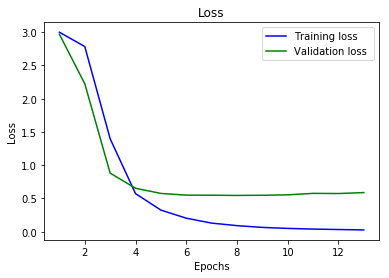

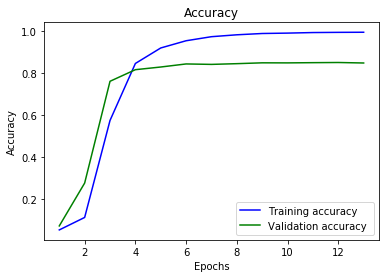

In [96]:
plot_history(history)

<img src="images/WORD2VEC DNN Accuracy.png" alt="Drawing" style="width: 600px;" />

### Increase in the vocabulary size allows for increase in the network size without deterioration of accuracy

## ConvNet

In [97]:
EMBEDDING_DIM = 64
filters = [32,32]
kernels = [2,3]
pool_sizes = [3,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name = 'sequence_input')
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, name = 'word_embedding')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(filters[0], kernels[0], activation='relu', name = 'conv1d_first')(embedded_sequences)
x = MaxPooling1D(pool_sizes[0], name ='max_pooling1d_first')(x)
x = Conv1D(filters[1], kernels[1], activation='relu', name = 'conv1d_second')(x)
x = MaxPooling1D(pool_sizes[1], name ='max_pooling1d_second')(x)
x = GlobalMaxPooling1D(name = 'global_max_pooling1d')(x)
preds = Dense(num_labels, activation='softmax', name = 'output_conv1d')(x)
model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  (None, 1100)              0         
_________________________________________________________________
word_embedding (Embedding)   (None, 1100, 64)          320064    
_________________________________________________________________
conv1d_first (Conv1D)        (None, 1099, 32)          4128      
_________________________________________________________________
max_pooling1d_first (MaxPool (None, 366, 32)           0         
_________________________________________________________________
conv1d_second (Conv1D)       (None, 364, 32)           3104      
_________________________________________________________________
max_pooling1d_second (MaxPoo (None, 72, 32)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
__________

## Explanation of Output Shape and Number of Parameters 

```
Layer (type)                 Output Shape              Param #   
=================================================================
sequence_input (InputLayer)  (None, 1100)              0       
```
#### Output Shape
- None: batch_size will be determined run-time
- 1100: Sequence Length

```
_________________________________________________________________
word_embedding (Embedding)   (None, 1100, 64)          320064      
```
#### Output Shape
- None: batch_size will be determined run-time
- 1100: Sequence Length
- 64: Word Embedding Dimensions

#### Number of Parameters 

- (Vocabulary Size + 1)  x Word Embedding Dimensions =  $5001 \times 64 = 320,064$  
    - 1 is added for the 0's of the padding

```
_________________________________________________________________
conv1d_first (Conv1D)        (None, 1099, 32)          4128          
```
#### Output Shape
- None: batch_size will be determined run-time
- 1099: Sequence Length - 1. The 1 is lost due to convolution with a Filter Size = 2
- 32: Number of Filters
#### Number of Parameters 

- Word Embedding Dimensions  x Number of Filters x Filter Size + Number of Filters=  $64 \times 32 \times 2 + 32= 4,128$ 
    - Number of Filters is added for the bias terms
<img src="images/Convnet Cube.png" alt="Drawing" style="width: 300px;" />

```
_________________________________________________________________
max_pooling1d_first (MaxPool (None, 366, 32)           0       
```
#### Output Shape
- None: batch_size will be determined run-time
- 366: (Sequence Length - 1) / Pool Size = 1099 / 3 = 366 (rounded down to)
- 32: Number of Channels in the Previous layer, which is the Number of Filters 

```
_________________________________________________________________
conv1d_second (Conv1D)       (None, 364, 32)           3104          
```
#### Output Shape
- None - batch_size will be determined run-time
- 364 - 366 - 2. The 2 is lost due to convolution with a Filter Size = 3
- 32 - Number of Filters

#### Number of Parameters 

- Number of Channels in the Previous layer  x Number of Filters x Filter Size + Number of Filters=  $32 \times 32 \times 3 + 32= 3,104$ 
    - Number of Filters is added for the bias terms

```
_________________________________________________________________
max_pooling1d_second (MaxPoo (None, 72, 32)            0       
```
#### Output Shape
- None - batch_size will be determined run-time
- 72: 364 / Pool Size = 364 / 5 = 72 (rounded down to)
- 32: Number of Channels in the Previous layer, which is the Number of Filters 

```
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0 
```
#### Output Shape
- None: batch_size will be determined run-time
- 32: Number of Channels in the Previous layer

```
_________________________________________________________________
output_conv1d (Dense)        (None, 20)                660   
```
#### Output Shape
- None: batch_size will be determined run-time
- 20: Output Layer Size

#### Number of Parameters
- (Global Max Pooling Size + 1) x  Output Layer Size = $33 \times 20 = 660$
    - 1 is added for the bias term


In [53]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=BATCH_SIZE, callbacks=[earlystop])

Train on 15016 samples, validate on 3830 samples
Epoch 1/30
15016/15016 [==============================] - 25s 2ms/step - loss: 2.9024 - acc: 0.1422 - val_loss: 2.5699 - val_acc: 0.3008
Epoch 2/30
15016/15016 [==============================] - 24s 2ms/step - loss: 1.7743 - acc: 0.5314 - val_loss: 1.2166 - val_acc: 0.6666
Epoch 3/30
15016/15016 [==============================] - 24s 2ms/step - loss: 0.8704 - acc: 0.7662 - val_loss: 0.8624 - val_acc: 0.7535
Epoch 4/30
15016/15016 [==============================] - 24s 2ms/step - loss: 0.5406 - acc: 0.8552 - val_loss: 0.7415 - val_acc: 0.7843
Epoch 5/30
15016/15016 [==============================] - 24s 2ms/step - loss: 0.3661 - acc: 0.9060 - val_loss: 0.7176 - val_acc: 0.7914
Epoch 6/30
15016/15016 [==============================] - 24s 2ms/step - loss: 0.2484 - acc: 0.9432 - val_loss: 0.7060 - val_acc: 0.8000
Epoch 7/30
15016/15016 [==============================] - 24s 2ms/step - loss: 0.1674 - acc: 0.9669 - val_loss: 0.7199 - val_acc:

In [54]:
print ('Best validation accuracy is ', max(history.history['val_acc']))

Best validation accuracy is  0.8086161882696824


### Overfitting occurs if trained too much 

Note, early stopping criteria kicked in at Epoch 11

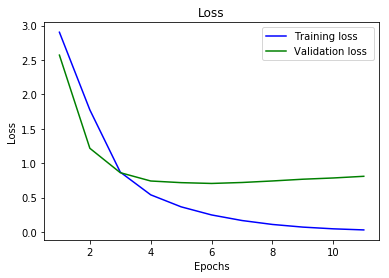

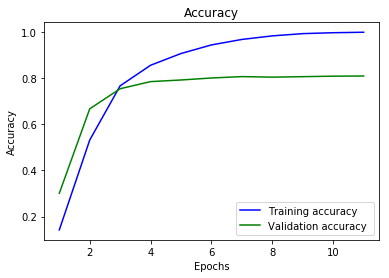

In [55]:
plot_history(history)

### Perform grid search for hyperparameter optimization

In [890]:
def run_cv(input_size, embedding_dim, data, labels, number_folds, n_layers, filters, kernels, pool_sizes,
           n_epochs = 30, patience= 5, verbose =1):
    results = []
    batch_size = 128
    for x_train, y_train, x_test, y_test in create_all_folds(data, labels, number_folds):
        model = conv1D_sequence_model_def(input_size, embedding_dim, n_layers, 
                                             filters, kernels, pool_sizes, verbose = 0)
        earlystop = EarlyStopping(monitor='val_loss', patience=patience)
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=n_epochs, 
                        batch_size=batch_size, verbose = 0, callbacks=[earlystop])
        accuracy = max(history.history['val_acc'])
        del x_train, x_test, y_train, y_test
        #gc.collect()
        if verbose == 1:
            print ('Best validation accuracy is ', accuracy)
        results.append(accuracy)
    mean_acc = np.mean(results)
    std_acc = np.std(results)
    return (mean_acc, std_acc)

In [891]:
def conv1D_sequence_model_def(input_size, embedding_dim, n_layers, number_filters, kernels, pool_sizes, verbose = False):
    sequence_input = Input(shape=(input_size,), dtype='int32', name = 'sequence_input')
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, input_length=input_size, name = 'word_embedding')
    x = embedding_layer(sequence_input)

    for i in range(n_layers):
        x = Conv1D(filters[i], kernels[i], activation='relu', name = 'conv1d_first')(x)
        x = MaxPooling1D(pool_sizes[i], name ='max_pooling1d_first')(x)
    x = GlobalMaxPooling1D(name = 'global_max_pooling1d')(x)
    preds = Dense(num_labels, activation='softmax', name = 'output_conv1d')(x)
    model = Model(sequence_input, preds)
    
    if verbose: 
        model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

In [ ]:
%%time
results = {'embedding_dim':[], 'mean_acc':[], 'std_acc':[]}
filters = [32,32]
kernels = [2,3]
pool_sizes = [3,5]
number_folds = 5
n_layers = 2
input_size = MAX_SEQUENCE_LENGTH
embedding_dim_set = [8,16,32,64,128,256,512,1028]
for embedding_dim in embedding_dim_set:
    results['embedding_dim'].append(embedding_dim)
    m, s = run_cv(input_size, embedding_dim, sequence_data, cat_data_labels, number_folds, 
                  n_layers, filters, kernels,pool_sizes, patience= 5)
    results['mean_acc'].append(m)
    results['std_acc'].append(s)

In [896]:
results

{'embedding_dim': [8, 16, 32, 64, 128, 256, 512, 1028],
 'mean_acc': [0.8439647740925136,
  0.8648821757761999,
  0.8738042886660653,
  0.881992831758055,
  0.8838656279510712,
  0.8855289527078389,
  0.8820515607166763,
  0.884695699262865],
 'std_acc': [0.004022124370563573,
  0.003092485895523163,
  0.006446151036361878,
  0.008472682380729327,
  0.004316526345908498,
  0.008106580349402035,
  0.007074357808043372,
  0.004118346768984175]}

<img src="images/WORD2VEC CONVNET Sequence Accuracy.png" alt="Drawing" style="width: 600px;" />

### Increase in the vocabulary size allows for increase in the network size without deterioration of accuracy

## ConvNet in Parallel

In [305]:
EMBEDDING_DIM = 64
filters = [100,75,50]
kernels = [2,3,4]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name = 'sequence_input')
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, name = 'word_embedding')
embedded_sequences = embedding_layer(sequence_input)

branch1 = Conv1D(filters[0], kernels[0], name = 'conv1d_branch1')(embedded_sequences)
branch1 = GlobalMaxPooling1D(name = 'global_max_pooling1d_branch1')(branch1)

branch2 = Conv1D(filters[1], kernels[1], name = 'conv1d_branch2')(embedded_sequences)
branch2 = GlobalMaxPooling1D(name = 'global_max_pooling1d_branch2')(branch2)

branch3 = Conv1D(filters[2], kernels[2], name = 'conv1d_branch3')(embedded_sequences)
branch3 = GlobalMaxPooling1D(name = 'global_max_pooling1d_branch3')(branch3)

x = concatenate([branch1, branch2, branch3], name = 'concatenate')
x = Activation('relu', name='activation')(x)
preds = Dense(num_labels, activation='softmax', name = 'output_conv1d')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [306]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 1100)         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 1100, 64)     320064      sequence_input[0][0]             
__________________________________________________________________________________________________
conv1d_branch1 (Conv1D)         (None, 1099, 100)    12900       word_embedding[0][0]             
__________________________________________________________________________________________________
conv1d_branch2 (Conv1D)         (None, 1098, 75)     14475       word_embedding[0][0]             
__________________________________________________________________________________________________
conv1d_bra

## Explanation of Output Shape and Number of Parameters 

```
Layer (type)                 Output Shape              Param #   
=================================================================
sequence_input (InputLayer)  (None, 1100)              0       
```
#### Output Shape
- None: batch_size will be determined run-time
- 1100: Sequence Length

```
_________________________________________________________________
word_embedding (Embedding)   (None, 1100, 64)          320064      
```
#### Output Shape
- None: batch_size will be determined run-time
- 1100: Sequence Length
- 64: Word Embedding Dimensions

#### Number of Parameters 

- (Vocabulary Size + 1)  x Word Embedding Dimensions =  $5001 \times 64 = 320,064$ 
    - 1 is added for the unknown token, i.e. all the out-of-vocabulary words

```
_________________________________________________________________
conv1d_branch1 (Conv1D)        (None, 1099, 100)          12900          
```
#### Output Shape
- None: batch_size will be determined run-time
- 1099: Sequence Length - 1. The 1 is lost due to convolution with a Filter Size = 2
- 100: Number of Filters

#### Number of Parameters 

- Word Embedding Dimensions  x Number of Filters x Filter Size + Number of Filters=$64 \times 100 \times 2 + 100 = 12,900$ 
    - Number of Filters is added for the bias terms
<img src="images/Convnet Cube.png" alt="Drawing" style="width: 300px;" />

```
_________________________________________________________________
conv1d_branch2 (Conv1D)        (None, 1098, 75)          14475          
```
#### Output Shape
- None: batch_size will be determined run-time
- 1098: Sequence Length - 2. The 1 is lost due to convolution with a Filter Size = 3
- 75: Number of Filters

#### Number of Parameters 

- Word Embedding Dimensions  x Number of Filters x Filter Size + Number of Filters= $64 \times 75 \times 3 + 75 = 14,475$ 
    - Number of Filters is added for the bias terms

```
_________________________________________________________________
conv1d_branch3 (Conv1D)        (None, 1097, 50)          12850          
```
#### Output Shape
- None: batch_size will be determined run-time
- 1097: Sequence Length - 3. The 1 is lost due to convolution with a Filter Size = 4
- 50: Number of Filters

#### Number of Parameters 

- Word Embedding Dimensions  x Number of Filters x Filter Size + Number of Filters= $64 \times 50 \times 4 + 50 = 12,850$ 
    - Number of Filters is added for the bias terms
    
```
_________________________________________________________________
concatenate (Concatenate)       (None, 225)          0 
```
#### Output Shape
- None: batch_size will be determined run-time
- 225: Sum of the Number of Channels in the Concatenated layers $100 + 75 + 50 = 225$


```
activation (Activation)         (None, 225)          0                          
__________________________________________________________________________________________________
output_conv1d (Dense)           (None, 20)           4520 
```
#### Output Shape
- None: batch_size will be determined run-time
- 20: Output Layer Size

#### Number of Parameters
- (Concatenated Size + 1) x  Output Layer Size = $226 \times 20 = 4520$
    - 1 is added for the bias term


In [307]:
%%time
earlystop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=BATCH_SIZE, callbacks=[earlystop])

Train on 15105 samples, validate on 3741 samples
Epoch 1/50
15105/15105 [==============================] - 144s 10ms/step - loss: 2.7102 - acc: 0.3567 - val_loss: 1.9352 - val_acc: 0.6362
Epoch 2/50
15105/15105 [==============================] - 146s 10ms/step - loss: 1.2608 - acc: 0.7186 - val_loss: 0.8936 - val_acc: 0.7632
Epoch 3/50
15105/15105 [==============================] - 141s 9ms/step - loss: 0.6805 - acc: 0.8173 - val_loss: 0.6419 - val_acc: 0.8161
Epoch 4/50
15105/15105 [==============================] - 141s 9ms/step - loss: 0.4518 - acc: 0.8783 - val_loss: 0.5347 - val_acc: 0.8455
Epoch 5/50
15105/15105 [==============================] - 145s 10ms/step - loss: 0.3146 - acc: 0.9210 - val_loss: 0.4775 - val_acc: 0.8602
Epoch 6/50
15105/15105 [==============================] - 151s 10ms/step - loss: 0.2250 - acc: 0.9480 - val_loss: 0.4472 - val_acc: 0.8690
Epoch 7/50
15105/15105 [==============================] - 144s 10ms/step - loss: 0.1498 - acc: 0.9721 - val_loss: 0.424

In [308]:
print ('Best validation accuracy is ', max(history.history['val_acc']))

Best validation accuracy is  0.8861267039464202


### Overfitting occurs if trained too much 

Note, early stopping criteria kicked in at Epoch 15

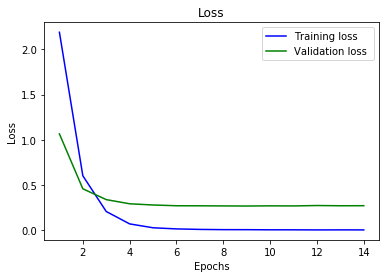

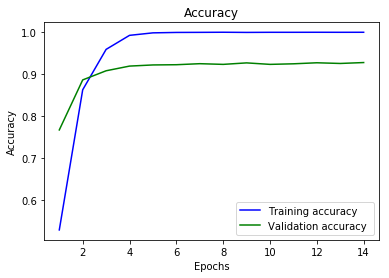

In [302]:
plot_history(history)

### Perform grid search for hyperparameter optimization

In [34]:
def run_cv_parallel(input_size, embedding_dim, data, labels, number_folds, n_branches, filters, kernels, 
           n_epochs = 30, patience= 5, verbose =1):
    results = []
    batch_size = 128
    for x_train, y_train, x_test, y_test in create_all_folds(data, labels, number_folds):
        model = conv1D_parallel_model_def(input_size, embedding_dim, n_branches, 
                                             filters, kernels,  verbose = 0)
        earlystop = EarlyStopping(monitor='val_loss', patience=patience)
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=n_epochs, 
                        batch_size=batch_size, verbose = 0, callbacks=[earlystop])
        accuracy = max(history.history['val_acc'])
        del x_train, x_test, y_train, y_test
        #gc.collect()
        if verbose == 1:
            print ('Best validation accuracy is ', accuracy)
        results.append(accuracy)
    mean_acc = np.mean(results)
    std_acc = np.std(results)
    return (mean_acc, std_acc)

In [39]:
def conv1D_parallel_model_def(input_size, embedding_dim, n_branches, number_filters, kernels, verbose = False):
    sequence_input = Input(shape=(input_size,), dtype='int32', name = 'sequence_input')
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, input_length=input_size, name = 'word_embedding')
    embedded_sequences = embedding_layer(sequence_input)

    branches = []
    for i in range(n_branches):
        y = Conv1D(filters[i], kernels[i], activation='relu')(embedded_sequences)
        y = GlobalMaxPooling1D()(y)
        branches.append(y)
    x = concatenate(branches)
    x = Activation('relu')(x)
    preds = Dense(num_labels, activation='softmax')(x)
    model = Model(sequence_input, preds)
    
    if verbose: 
        model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

In [ ]:
%%time
results = {'embedding_dim':[], 'vocab_size':[],'mean_acc':[], 'std_acc':[]}
filters = [100,75,50]
kernels = [2,3,4]
number_folds = 5
n_branches = 3
embedding_dim_set = [8,16,32,64,128,256,512,1028]
for vocab_size in [5000,15000]:
    seq_data, word_index = make_sequences(data, vocab_size, percentile=99)
    input_size = seq_data.shape[1]
    for embedding_dim in embedding_dim_set:
        results['embedding_dim'].append(embedding_dim)
        results['vocab_size'].append(vocab_size)
        m, s = run_cv_parallel(input_size, embedding_dim, seq_data, cat_data_labels, number_folds, 
                      n_branches, filters, kernels, patience= 5)
        results['mean_acc'].append(m)
        results['std_acc'].append(s)

It took almost 6 days to run the grid search for vocab_size = 1500:

CPU times: user 10d 7h 47min 55s, sys: 16h 40min 37s, total: 11d 28min 33s

Wall time: 5d 15h 24min 19s

<img src="images/WORD2VEC CONVNET Parallel Accuracy.png?modified=12345678" alt="Drawing" style="width: 600px;" />

## Translational Invariance

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

In [74]:
word_index['cpu']

964

<img src="images/Translational Invariance.png" alt="Drawing" style="width: 600px;" />

In [ ]:
sequence = np.zeros((1,1100))
sequence[0][0] = 964
#a sequence with the word 'cpu' in the beginning and the rest are 0's
predict_0 = model.predict(sequence)[0]
sequence = np.zeros((1,1100))
sequence[0][1] = 964
#a sequence with the word 'cpu' in the second position and the rest are 0's
predict_1 = model.predict(sequence)[0]
sequence = np.zeros((1,1100))
sequence[0][10] = 964
#a sequence with the word 'cpu' in the 11's position and the rest are 0's
predict_10 = model.predict(sequence)[0]
sequence = np.zeros((1,1100))
sequence[0][100] = 964
#a sequence with the word 'cpu' in the 101's position and the rest are 0's
predict_100 = model.predict(sequence)[0]
sequence = np.zeros((1,1100))
sequence[0][1099] = 964
#a sequence with the word 'cpu' in the last position and the rest are 0's
predict_last = model.predict(sequence)[0]

### predict_0, etc. are predicted probabilities of the 20 topics, given the word sequence, which is really just the word 'cpu' at different positions in the sequence of 0's

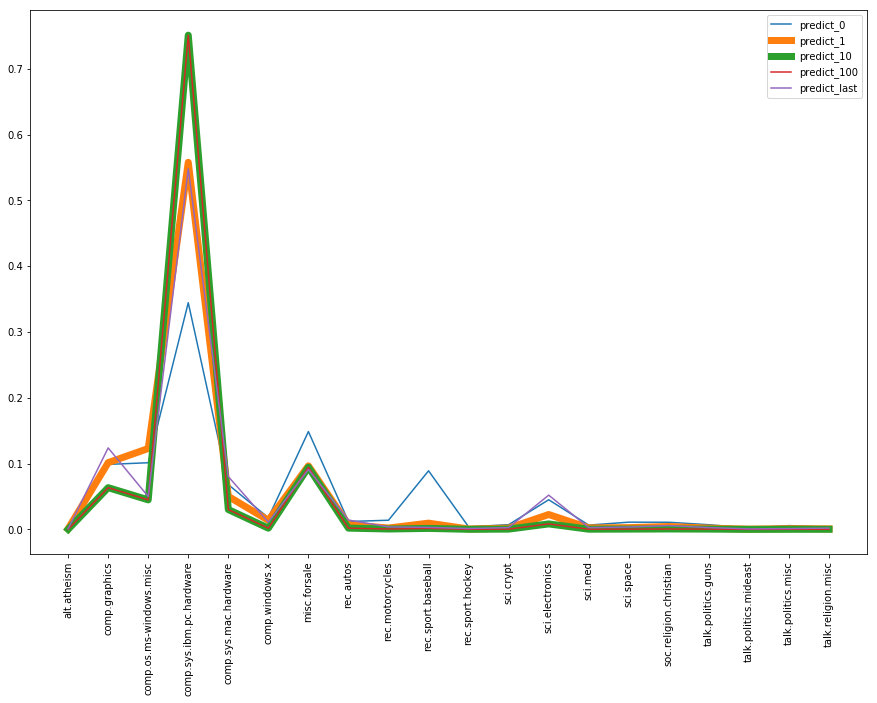

In [259]:
plt.figure(figsize=(15,10))
plt.plot(predict_0, label='predict_0')
plt.plot(predict_1, label='predict_1', linewidth=7.0)
plt.plot(predict_10,  label='predict_10', linewidth=7.0)
plt.plot(predict_100, label='predict_100')
plt.plot(predict_last, label='predict_last')
plt.xticks(np.arange(num_labels))
ax = plt.axes()

ax.set_xticklabels(np.array(data_label_names), rotation=90)
plt.legend()
plt.show()

#### Try different words to see which topics they predict

In [210]:
pitching_index = word_index['pitching']
baseball_index = word_index['baseball']
christians_index = word_index['christians']
cpu_index = word_index['cpu']

In [232]:
#try to comment some of the lines
sequence = np.zeros((1,1100))
sequence[0][410] = pitching_index 
sequence[0][511] = christians_index 
sentsequenceence[0][512] = cpu_index 
sequence[0][513] = cpu_index 
data_label_names[np.argmax(model.predict(sequence))]

'comp.sys.ibm.pc.hardware'

## The word embeddings have learned some semantic similarity even though the only goal was text classification

### Copy the word embeddings into a gensim's Word2Vec model to find similar words efficiently

In [135]:
embedding_layer_weights =  model.layers[1].get_weights()[0]

In [136]:
all_tokens = [x.split() for x in data]

In [137]:
model_w2v = models.Word2Vec(sg = 1, size=64) #sg=1 skip-a-gram
model_w2v.build_vocab(all_tokens)

In [138]:
#to change the vectors without creating a new model
#have to reset the vectors cashed by most_similar
model_w2v.wv.vectors_norm = None

In [139]:
model_w2v.wv.vectors  = embedding_layer_weights[2:,:] # the first two are 0 padding and UNK

### Find similar words

In [140]:
model_w2v.wv.most_similar(positive=['christians'], topn=10)

[('catholic', 0.8506920337677002),
 ('luke', 0.7527848482131958),
 ('founded', 0.7421770095825195),
 ('ye', 0.678794264793396),
 ('commonly', 0.6145917773246765),
 ('ups', 0.5935655832290649),
 ('living', 0.5869908928871155),
 ('century', 0.5866395235061646),
 ('koresh', 0.563356876373291),
 ('bos', 0.5430530309677124)]

In [141]:
model_w2v.wv.most_similar(positive=['cpu'], topn=10)

[('config', 0.6700758337974548),
 ('busy', 0.6633105874061584),
 ('modem', 0.6468589901924133),
 ('pcs', 0.6393556594848633),
 ('linear', 0.6344971060752869),
 ('programmer', 0.6251541376113892),
 ('memory', 0.6202409267425537),
 ('cat', 0.6051343679428101),
 ('computers', 0.604193925857544),
 ('installed', 0.598760724067688)]

In [142]:
model_w2v.wv.most_similar(positive=['baseball'], topn=10) 

[('defensive', 0.7596086859703064),
 ('yankees', 0.753547191619873),
 ('league', 0.7222006320953369),
 ('pitching', 0.6910199522972107),
 ('ted', 0.689267098903656),
 ('agent', 0.6745107769966125),
 ('asd', 0.6468268632888794),
 ('batting', 0.6451112031936646),
 ('hit', 0.6194806098937988),
 ('career', 0.6016578674316406)]